# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('y_test: ', (1000,))
('X_val: ', (1000, 3, 32, 32))
('X_test: ', (1000, 3, 32, 32))
('y_train: ', (49000,))
('X_train: ', (49000, 3, 32, 32))
('y_val: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

In [4]:
N, *_ = x.shape
out = np.dot(x.reshape(N,-1), w) + b

In [5]:
b

array([-0.3, -0.1,  0.1])

In [6]:
b.reshape(1, -1)

array([[-0.3, -0.1,  0.1]])

In [7]:
np.dot(x.reshape(2,-1), w)

array([[1.79834967, 1.80660132, 1.81485297],
       [3.55553199, 3.6141327 , 3.67273342]])

In [8]:
np.dot(x.reshape(2,-1), w) + b

array([[1.49834967, 1.70660132, 1.91485297],
       [3.25553199, 3.5141327 , 3.77273342]])

In [9]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [10]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [11]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [12]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [13]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [14]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [15]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [16]:
model = TwoLayerNet()
solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

In [17]:
solver.check_accuracy(data['X_test'], data['y_test'])

0.502

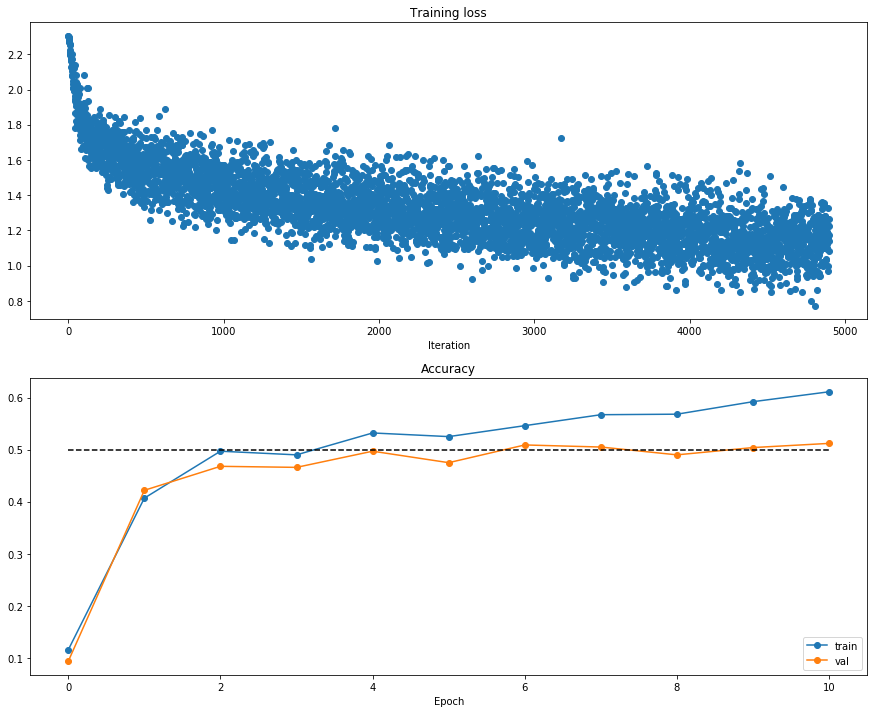

In [18]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [22]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

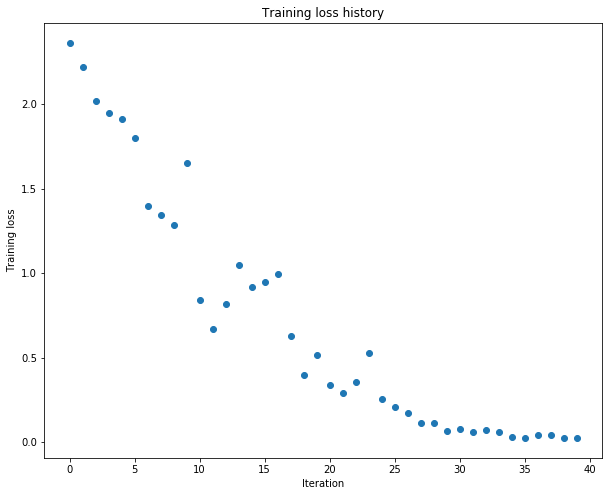

In [23]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 5.557032
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.085000
(Epoch 2 / 20) train acc: 0.260000; val_acc: 0.116000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.125000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.139000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.133000
(Iteration 11 / 40) loss: 0.919214
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.134000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.150000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.146000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.140000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.147000
(Iteration 21 / 40) loss: 0.304914
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.149000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.143000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.155000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.138000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.141000
(Iteration 31 / 40) loss: 

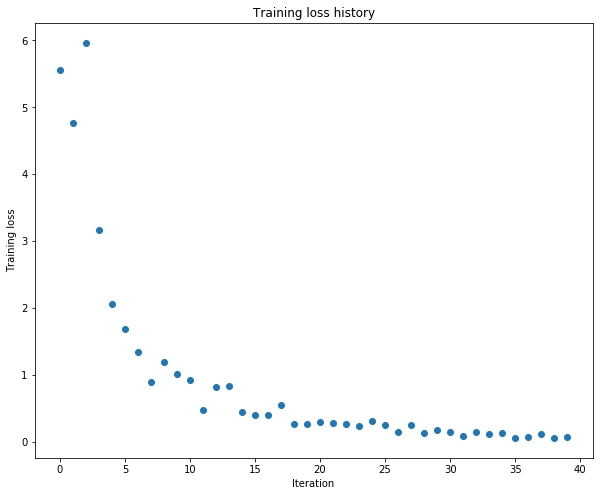

In [24]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2 #1e-2 #1(all over) #1e-2(still low) #1e-3 (too low)
weight_scale = .05 #1e-2 #1e-2 (exploded) #5
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
Hard to converge, either too slow or doesnt converge easily. Frustrating. Keeping learning rate constant when it's converging, and playing with weight initialization, got me to the solution. So the proper answer: (drumroll, please!)

Deeper network is sensitive to weight initialization.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [25]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082694
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.024528
(Iteration 71 / 200) loss: 2.024628
(Epoch 2 / 5) train acc: 0.350000; val_acc: 0.308000
(Iteration 81 / 200) loss: 1.804535
(Iteration 91 / 200) loss: 1.917276
(Iteration 101 / 200) loss: 1.923032
(Iteration 111 / 200) loss: 1.707939
(Epoch 3 / 5) train acc: 0.401000; val_acc: 0.321000
(Iteration 121 / 200) loss: 1.704839
(Iteration 131 / 200) loss: 1.766843
(Iteration 141 / 200) loss: 1.788663
(Iteration 151 / 200) loss: 1.828742
(Epoch 4 / 5) train acc: 0.420000; val_acc: 0.320000
(Iteration 161 / 200) loss: 1.628797
(Iteration 171 / 200) loss: 1.902930
(Iteration 181 / 200) loss: 1.542250
(Iteration 191 / 200) los

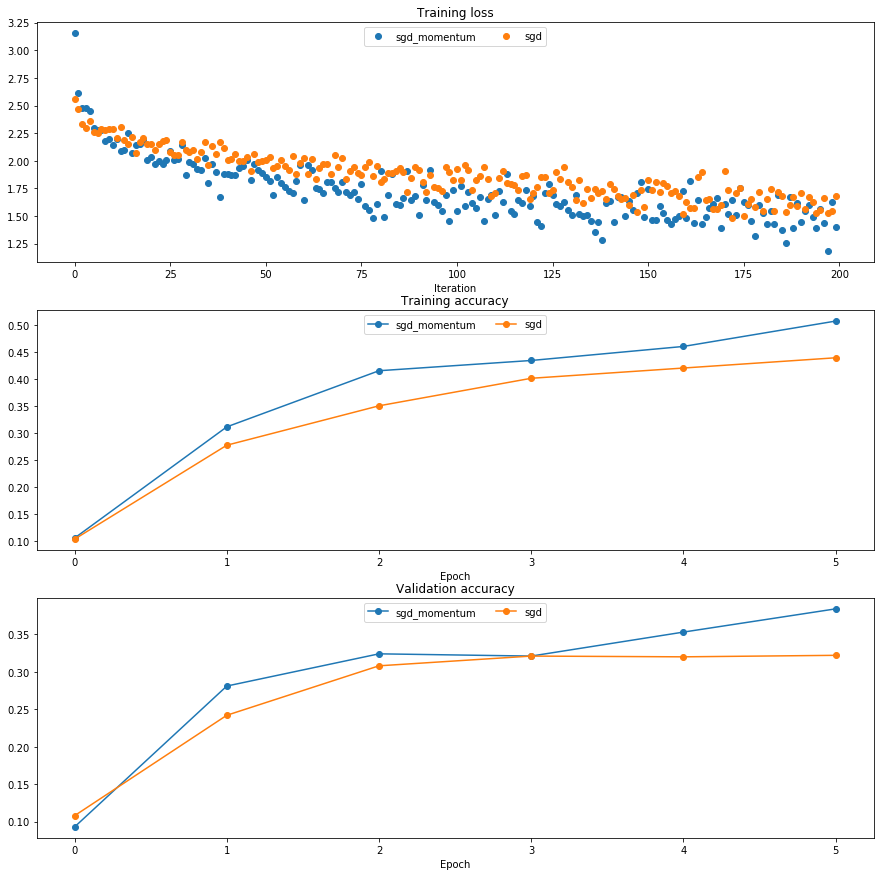

In [26]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [27]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [28]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.0015218451757856217
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505558
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519017
(Iteration 101 / 200) loss: 1.368522
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464705
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.415069
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382818
(Iteration 171 / 200) loss: 1.359900
(Iteration 181 / 200) loss: 1.095947
(Iteration 191 / 200) lo

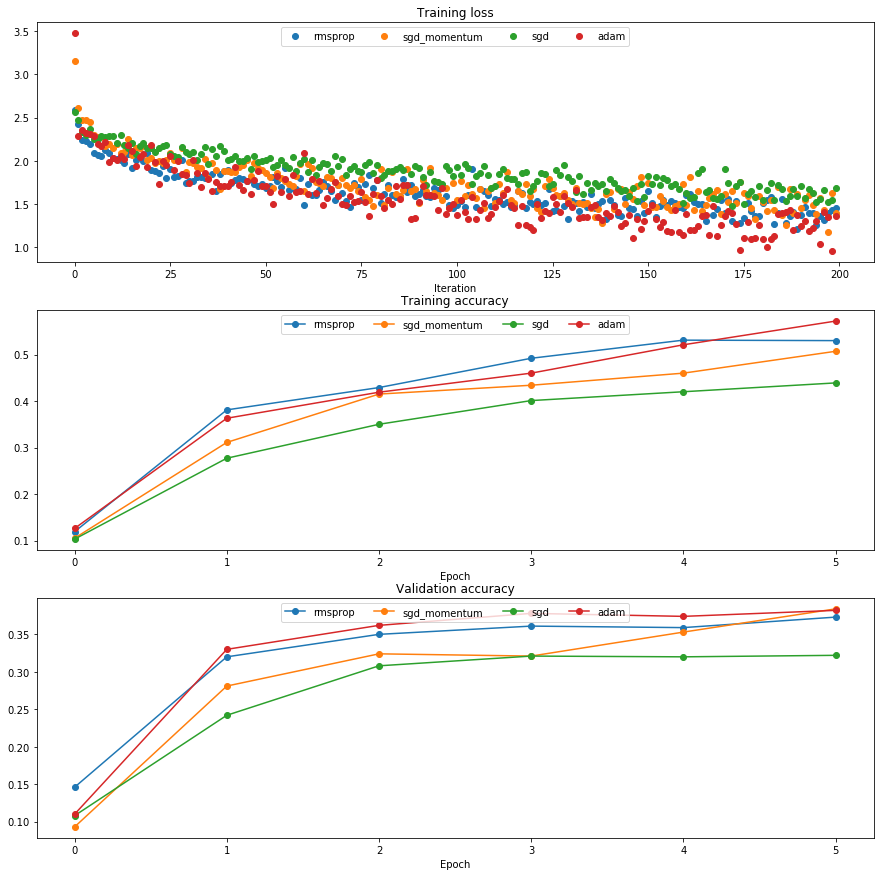

In [29]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

(Iteration 1 / 2000) loss: 15.716285
(Epoch 0 / 1000) train acc: 0.131000; val_acc: 0.118000
(Epoch 1 / 1000) train acc: 0.102000; val_acc: 0.092000
(Epoch 2 / 1000) train acc: 0.170000; val_acc: 0.192000
(Epoch 3 / 1000) train acc: 0.231000; val_acc: 0.204000
(Epoch 4 / 1000) train acc: 0.223000; val_acc: 0.190000
(Epoch 5 / 1000) train acc: 0.204000; val_acc: 0.182000
(Epoch 6 / 1000) train acc: 0.206000; val_acc: 0.193000
(Epoch 7 / 1000) train acc: 0.178000; val_acc: 0.180000
(Epoch 8 / 1000) train acc: 0.188000; val_acc: 0.173000
(Epoch 9 / 1000) train acc: 0.188000; val_acc: 0.149000
(Epoch 10 / 1000) train acc: 0.150000; val_acc: 0.123000
(Epoch 11 / 1000) train acc: 0.146000; val_acc: 0.131000
(Epoch 12 / 1000) train acc: 0.160000; val_acc: 0.157000
(Epoch 13 / 1000) train acc: 0.137000; val_acc: 0.149000
(Epoch 14 / 1000) train acc: 0.135000; val_acc: 0.132000
(Epoch 15 / 1000) train acc: 0.193000; val_acc: 0.143000
(Epoch 16 / 1000) train acc: 0.146000; val_acc: 0.128000
(Epo

(Epoch 143 / 1000) train acc: 0.188000; val_acc: 0.192000
(Epoch 144 / 1000) train acc: 0.209000; val_acc: 0.205000
(Epoch 145 / 1000) train acc: 0.197000; val_acc: 0.175000
(Epoch 146 / 1000) train acc: 0.197000; val_acc: 0.185000
(Epoch 147 / 1000) train acc: 0.167000; val_acc: 0.186000
(Epoch 148 / 1000) train acc: 0.202000; val_acc: 0.178000
(Epoch 149 / 1000) train acc: 0.205000; val_acc: 0.190000
(Epoch 150 / 1000) train acc: 0.211000; val_acc: 0.182000
(Epoch 151 / 1000) train acc: 0.202000; val_acc: 0.195000
(Epoch 152 / 1000) train acc: 0.201000; val_acc: 0.224000
(Epoch 153 / 1000) train acc: 0.235000; val_acc: 0.206000
(Epoch 154 / 1000) train acc: 0.209000; val_acc: 0.213000
(Epoch 155 / 1000) train acc: 0.218000; val_acc: 0.200000
(Epoch 156 / 1000) train acc: 0.210000; val_acc: 0.188000
(Epoch 157 / 1000) train acc: 0.223000; val_acc: 0.195000
(Epoch 158 / 1000) train acc: 0.214000; val_acc: 0.226000
(Epoch 159 / 1000) train acc: 0.217000; val_acc: 0.219000
(Epoch 160 / 1

(Epoch 284 / 1000) train acc: 0.220000; val_acc: 0.227000
(Epoch 285 / 1000) train acc: 0.235000; val_acc: 0.228000
(Epoch 286 / 1000) train acc: 0.238000; val_acc: 0.242000
(Epoch 287 / 1000) train acc: 0.254000; val_acc: 0.249000
(Epoch 288 / 1000) train acc: 0.251000; val_acc: 0.205000
(Epoch 289 / 1000) train acc: 0.245000; val_acc: 0.205000
(Epoch 290 / 1000) train acc: 0.267000; val_acc: 0.217000
(Epoch 291 / 1000) train acc: 0.247000; val_acc: 0.236000
(Epoch 292 / 1000) train acc: 0.275000; val_acc: 0.240000
(Epoch 293 / 1000) train acc: 0.273000; val_acc: 0.239000
(Epoch 294 / 1000) train acc: 0.300000; val_acc: 0.242000
(Epoch 295 / 1000) train acc: 0.251000; val_acc: 0.227000
(Epoch 296 / 1000) train acc: 0.243000; val_acc: 0.243000
(Epoch 297 / 1000) train acc: 0.247000; val_acc: 0.242000
(Epoch 298 / 1000) train acc: 0.250000; val_acc: 0.239000
(Epoch 299 / 1000) train acc: 0.247000; val_acc: 0.232000
(Epoch 300 / 1000) train acc: 0.260000; val_acc: 0.231000
(Epoch 301 / 1

(Epoch 426 / 1000) train acc: 0.343000; val_acc: 0.279000
(Epoch 427 / 1000) train acc: 0.292000; val_acc: 0.246000
(Epoch 428 / 1000) train acc: 0.300000; val_acc: 0.228000
(Epoch 429 / 1000) train acc: 0.316000; val_acc: 0.230000
(Epoch 430 / 1000) train acc: 0.344000; val_acc: 0.255000
(Epoch 431 / 1000) train acc: 0.320000; val_acc: 0.254000
(Epoch 432 / 1000) train acc: 0.356000; val_acc: 0.271000
(Epoch 433 / 1000) train acc: 0.346000; val_acc: 0.256000
(Epoch 434 / 1000) train acc: 0.319000; val_acc: 0.247000
(Epoch 435 / 1000) train acc: 0.310000; val_acc: 0.245000
(Epoch 436 / 1000) train acc: 0.317000; val_acc: 0.266000
(Epoch 437 / 1000) train acc: 0.332000; val_acc: 0.263000
(Epoch 438 / 1000) train acc: 0.325000; val_acc: 0.254000
(Epoch 439 / 1000) train acc: 0.305000; val_acc: 0.241000
(Epoch 440 / 1000) train acc: 0.307000; val_acc: 0.244000
(Epoch 441 / 1000) train acc: 0.273000; val_acc: 0.243000
(Epoch 442 / 1000) train acc: 0.309000; val_acc: 0.235000
(Epoch 443 / 1

(Epoch 567 / 1000) train acc: 0.333000; val_acc: 0.237000
(Epoch 568 / 1000) train acc: 0.322000; val_acc: 0.220000
(Epoch 569 / 1000) train acc: 0.368000; val_acc: 0.224000
(Epoch 570 / 1000) train acc: 0.366000; val_acc: 0.237000
(Epoch 571 / 1000) train acc: 0.341000; val_acc: 0.238000
(Epoch 572 / 1000) train acc: 0.350000; val_acc: 0.246000
(Epoch 573 / 1000) train acc: 0.320000; val_acc: 0.226000
(Epoch 574 / 1000) train acc: 0.351000; val_acc: 0.222000
(Epoch 575 / 1000) train acc: 0.376000; val_acc: 0.237000
(Epoch 576 / 1000) train acc: 0.361000; val_acc: 0.234000
(Epoch 577 / 1000) train acc: 0.368000; val_acc: 0.239000
(Epoch 578 / 1000) train acc: 0.367000; val_acc: 0.233000
(Epoch 579 / 1000) train acc: 0.401000; val_acc: 0.251000
(Epoch 580 / 1000) train acc: 0.359000; val_acc: 0.244000
(Epoch 581 / 1000) train acc: 0.325000; val_acc: 0.217000
(Epoch 582 / 1000) train acc: 0.339000; val_acc: 0.204000
(Epoch 583 / 1000) train acc: 0.371000; val_acc: 0.233000
(Epoch 584 / 1

(Epoch 709 / 1000) train acc: 0.398000; val_acc: 0.225000
(Epoch 710 / 1000) train acc: 0.406000; val_acc: 0.243000
(Epoch 711 / 1000) train acc: 0.383000; val_acc: 0.240000
(Epoch 712 / 1000) train acc: 0.371000; val_acc: 0.225000
(Epoch 713 / 1000) train acc: 0.357000; val_acc: 0.209000
(Epoch 714 / 1000) train acc: 0.391000; val_acc: 0.232000
(Epoch 715 / 1000) train acc: 0.419000; val_acc: 0.243000
(Epoch 716 / 1000) train acc: 0.428000; val_acc: 0.242000
(Epoch 717 / 1000) train acc: 0.370000; val_acc: 0.230000
(Epoch 718 / 1000) train acc: 0.337000; val_acc: 0.210000
(Epoch 719 / 1000) train acc: 0.380000; val_acc: 0.220000
(Epoch 720 / 1000) train acc: 0.360000; val_acc: 0.220000
(Epoch 721 / 1000) train acc: 0.392000; val_acc: 0.224000
(Epoch 722 / 1000) train acc: 0.342000; val_acc: 0.212000
(Epoch 723 / 1000) train acc: 0.334000; val_acc: 0.209000
(Epoch 724 / 1000) train acc: 0.376000; val_acc: 0.232000
(Epoch 725 / 1000) train acc: 0.363000; val_acc: 0.237000
(Epoch 726 / 1

(Epoch 850 / 1000) train acc: 0.405000; val_acc: 0.225000
(Epoch 851 / 1000) train acc: 0.400000; val_acc: 0.226000
(Epoch 852 / 1000) train acc: 0.419000; val_acc: 0.229000
(Epoch 853 / 1000) train acc: 0.470000; val_acc: 0.248000
(Epoch 854 / 1000) train acc: 0.454000; val_acc: 0.250000
(Epoch 855 / 1000) train acc: 0.416000; val_acc: 0.234000
(Epoch 856 / 1000) train acc: 0.394000; val_acc: 0.220000
(Epoch 857 / 1000) train acc: 0.387000; val_acc: 0.212000
(Epoch 858 / 1000) train acc: 0.389000; val_acc: 0.210000
(Epoch 859 / 1000) train acc: 0.389000; val_acc: 0.231000
(Epoch 860 / 1000) train acc: 0.387000; val_acc: 0.241000
(Epoch 861 / 1000) train acc: 0.398000; val_acc: 0.242000
(Epoch 862 / 1000) train acc: 0.436000; val_acc: 0.242000
(Epoch 863 / 1000) train acc: 0.390000; val_acc: 0.250000
(Epoch 864 / 1000) train acc: 0.392000; val_acc: 0.234000
(Epoch 865 / 1000) train acc: 0.380000; val_acc: 0.220000
(Epoch 866 / 1000) train acc: 0.387000; val_acc: 0.219000
(Epoch 867 / 1

(Epoch 992 / 1000) train acc: 0.401000; val_acc: 0.233000
(Epoch 993 / 1000) train acc: 0.426000; val_acc: 0.243000
(Epoch 994 / 1000) train acc: 0.456000; val_acc: 0.243000
(Epoch 995 / 1000) train acc: 0.450000; val_acc: 0.229000
(Epoch 996 / 1000) train acc: 0.453000; val_acc: 0.221000
(Epoch 997 / 1000) train acc: 0.458000; val_acc: 0.240000
(Epoch 998 / 1000) train acc: 0.479000; val_acc: 0.238000
(Epoch 999 / 1000) train acc: 0.452000; val_acc: 0.233000
(Epoch 1000 / 1000) train acc: 0.463000; val_acc: 0.226000


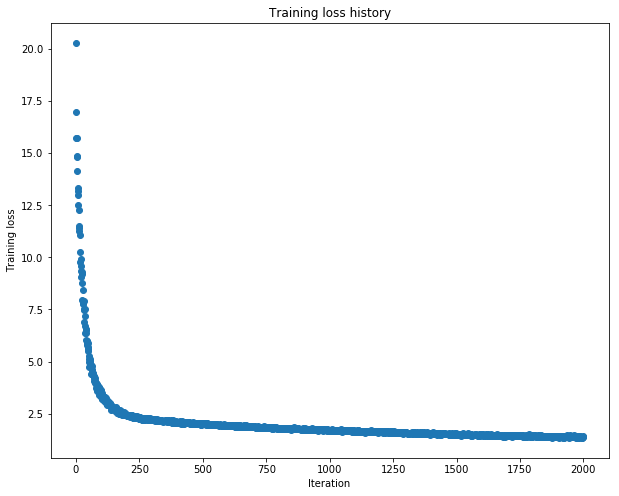

In [61]:
learning_rate = 5e-3
weight_scale = .05

model = FullyConnectedNet([100, 300, 5100], dropout=0.9, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=1000, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 1000) loss: 3.430131
(Epoch 0 / 500) train acc: 0.118000; val_acc: 0.141000
(Epoch 1 / 500) train acc: 0.136000; val_acc: 0.177000
(Epoch 2 / 500) train acc: 0.191000; val_acc: 0.196000
(Epoch 3 / 500) train acc: 0.196000; val_acc: 0.230000
(Epoch 4 / 500) train acc: 0.243000; val_acc: 0.244000
(Epoch 5 / 500) train acc: 0.251000; val_acc: 0.253000
(Epoch 6 / 500) train acc: 0.259000; val_acc: 0.260000
(Epoch 7 / 500) train acc: 0.301000; val_acc: 0.261000
(Epoch 8 / 500) train acc: 0.272000; val_acc: 0.263000
(Epoch 9 / 500) train acc: 0.292000; val_acc: 0.259000
(Epoch 10 / 500) train acc: 0.286000; val_acc: 0.262000
(Epoch 11 / 500) train acc: 0.277000; val_acc: 0.261000
(Epoch 12 / 500) train acc: 0.275000; val_acc: 0.256000
(Epoch 13 / 500) train acc: 0.267000; val_acc: 0.252000
(Epoch 14 / 500) train acc: 0.277000; val_acc: 0.253000
(Epoch 15 / 500) train acc: 0.252000; val_acc: 0.252000
(Epoch 16 / 500) train acc: 0.265000; val_acc: 0.257000
(Epoch 17 / 500) train

(Epoch 146 / 500) train acc: 0.439000; val_acc: 0.338000
(Epoch 147 / 500) train acc: 0.453000; val_acc: 0.343000
(Epoch 148 / 500) train acc: 0.470000; val_acc: 0.339000
(Epoch 149 / 500) train acc: 0.466000; val_acc: 0.332000
(Epoch 150 / 500) train acc: 0.461000; val_acc: 0.323000
(Epoch 151 / 500) train acc: 0.462000; val_acc: 0.327000
(Epoch 152 / 500) train acc: 0.444000; val_acc: 0.335000
(Epoch 153 / 500) train acc: 0.463000; val_acc: 0.335000
(Epoch 154 / 500) train acc: 0.445000; val_acc: 0.339000
(Epoch 155 / 500) train acc: 0.456000; val_acc: 0.336000
(Epoch 156 / 500) train acc: 0.437000; val_acc: 0.330000
(Epoch 157 / 500) train acc: 0.466000; val_acc: 0.333000
(Epoch 158 / 500) train acc: 0.454000; val_acc: 0.343000
(Epoch 159 / 500) train acc: 0.445000; val_acc: 0.350000
(Epoch 160 / 500) train acc: 0.499000; val_acc: 0.338000
(Epoch 161 / 500) train acc: 0.466000; val_acc: 0.334000
(Epoch 162 / 500) train acc: 0.444000; val_acc: 0.335000
(Epoch 163 / 500) train acc: 0.

(Epoch 290 / 500) train acc: 0.674000; val_acc: 0.355000
(Epoch 291 / 500) train acc: 0.691000; val_acc: 0.345000
(Epoch 292 / 500) train acc: 0.675000; val_acc: 0.356000
(Epoch 293 / 500) train acc: 0.702000; val_acc: 0.353000
(Epoch 294 / 500) train acc: 0.690000; val_acc: 0.354000
(Epoch 295 / 500) train acc: 0.683000; val_acc: 0.349000
(Epoch 296 / 500) train acc: 0.678000; val_acc: 0.354000
(Epoch 297 / 500) train acc: 0.718000; val_acc: 0.343000
(Epoch 298 / 500) train acc: 0.674000; val_acc: 0.350000
(Epoch 299 / 500) train acc: 0.698000; val_acc: 0.354000
(Epoch 300 / 500) train acc: 0.731000; val_acc: 0.351000
(Epoch 301 / 500) train acc: 0.714000; val_acc: 0.354000
(Epoch 302 / 500) train acc: 0.720000; val_acc: 0.352000
(Epoch 303 / 500) train acc: 0.702000; val_acc: 0.351000
(Epoch 304 / 500) train acc: 0.684000; val_acc: 0.348000
(Epoch 305 / 500) train acc: 0.727000; val_acc: 0.349000
(Epoch 306 / 500) train acc: 0.710000; val_acc: 0.355000
(Epoch 307 / 500) train acc: 0.

(Epoch 434 / 500) train acc: 0.877000; val_acc: 0.362000
(Epoch 435 / 500) train acc: 0.868000; val_acc: 0.370000
(Epoch 436 / 500) train acc: 0.883000; val_acc: 0.365000
(Epoch 437 / 500) train acc: 0.874000; val_acc: 0.356000
(Epoch 438 / 500) train acc: 0.883000; val_acc: 0.357000
(Epoch 439 / 500) train acc: 0.869000; val_acc: 0.355000
(Epoch 440 / 500) train acc: 0.870000; val_acc: 0.358000
(Epoch 441 / 500) train acc: 0.861000; val_acc: 0.365000
(Epoch 442 / 500) train acc: 0.878000; val_acc: 0.366000
(Epoch 443 / 500) train acc: 0.875000; val_acc: 0.358000
(Epoch 444 / 500) train acc: 0.881000; val_acc: 0.364000
(Epoch 445 / 500) train acc: 0.863000; val_acc: 0.370000
(Epoch 446 / 500) train acc: 0.887000; val_acc: 0.376000
(Epoch 447 / 500) train acc: 0.885000; val_acc: 0.358000
(Epoch 448 / 500) train acc: 0.889000; val_acc: 0.366000
(Epoch 449 / 500) train acc: 0.881000; val_acc: 0.377000
(Epoch 450 / 500) train acc: 0.891000; val_acc: 0.376000
(Epoch 451 / 500) train acc: 0.

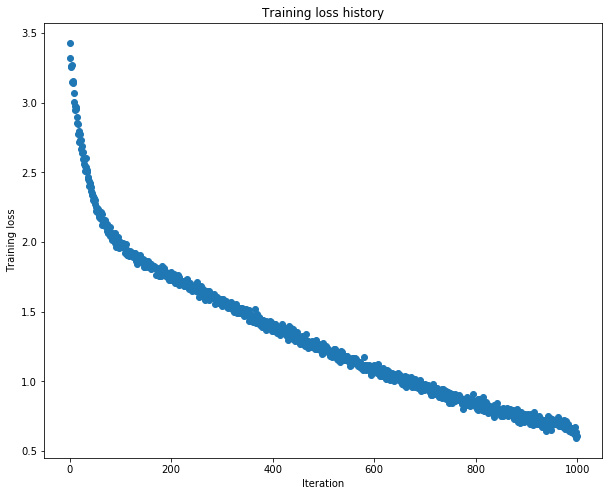

In [60]:
learning_rate = 1e-3
weight_scale = .05

model = FullyConnectedNet([500, 500, 500], dropout=0.8, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=500, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 100) loss: 3.040881
(Epoch 0 / 50) train acc: 0.177000; val_acc: 0.197000
(Epoch 1 / 50) train acc: 0.189000; val_acc: 0.187000
(Epoch 2 / 50) train acc: 0.248000; val_acc: 0.232000
(Epoch 3 / 50) train acc: 0.237000; val_acc: 0.240000
(Epoch 4 / 50) train acc: 0.242000; val_acc: 0.255000
(Epoch 5 / 50) train acc: 0.278000; val_acc: 0.266000
(Epoch 6 / 50) train acc: 0.282000; val_acc: 0.279000
(Epoch 7 / 50) train acc: 0.284000; val_acc: 0.283000
(Epoch 8 / 50) train acc: 0.275000; val_acc: 0.285000
(Epoch 9 / 50) train acc: 0.319000; val_acc: 0.292000
(Epoch 10 / 50) train acc: 0.306000; val_acc: 0.297000
(Epoch 11 / 50) train acc: 0.292000; val_acc: 0.302000
(Epoch 12 / 50) train acc: 0.324000; val_acc: 0.311000
(Epoch 13 / 50) train acc: 0.332000; val_acc: 0.309000
(Epoch 14 / 50) train acc: 0.322000; val_acc: 0.298000
(Epoch 15 / 50) train acc: 0.335000; val_acc: 0.321000
(Epoch 16 / 50) train acc: 0.340000; val_acc: 0.330000
(Epoch 17 / 50) train acc: 0.336000; val

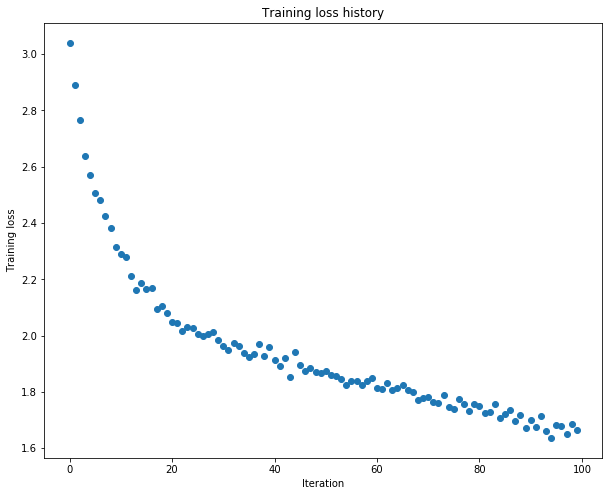

In [58]:
learning_rate = 5e-3
weight_scale = .05

model = FullyConnectedNet([500, 500, 500], dropout=0.7, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 100) loss: 2.654734
(Epoch 0 / 50) train acc: 0.162000; val_acc: 0.155000
(Epoch 1 / 50) train acc: 0.212000; val_acc: 0.183000
(Epoch 2 / 50) train acc: 0.232000; val_acc: 0.235000
(Epoch 3 / 50) train acc: 0.262000; val_acc: 0.269000
(Epoch 4 / 50) train acc: 0.290000; val_acc: 0.267000
(Epoch 5 / 50) train acc: 0.290000; val_acc: 0.278000
(Epoch 6 / 50) train acc: 0.292000; val_acc: 0.291000
(Epoch 7 / 50) train acc: 0.324000; val_acc: 0.308000
(Epoch 8 / 50) train acc: 0.336000; val_acc: 0.314000
(Epoch 9 / 50) train acc: 0.349000; val_acc: 0.329000
(Epoch 10 / 50) train acc: 0.366000; val_acc: 0.341000
(Epoch 11 / 50) train acc: 0.340000; val_acc: 0.336000
(Epoch 12 / 50) train acc: 0.369000; val_acc: 0.340000
(Epoch 13 / 50) train acc: 0.367000; val_acc: 0.348000
(Epoch 14 / 50) train acc: 0.362000; val_acc: 0.347000
(Epoch 15 / 50) train acc: 0.368000; val_acc: 0.344000
(Epoch 16 / 50) train acc: 0.392000; val_acc: 0.343000
(Epoch 17 / 50) train acc: 0.393000; val

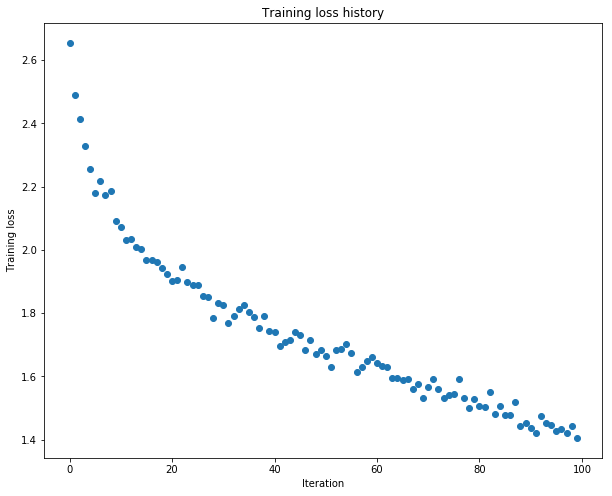

In [57]:
learning_rate = 5e-3
weight_scale = .05

model = FullyConnectedNet([500, 500, 500], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


(Iteration 1 / 100) loss: 2.648277
(Epoch 0 / 50) train acc: 0.176000; val_acc: 0.157000
(Epoch 1 / 50) train acc: 0.205000; val_acc: 0.171000
(Epoch 2 / 50) train acc: 0.230000; val_acc: 0.204000
(Epoch 3 / 50) train acc: 0.243000; val_acc: 0.234000
(Epoch 4 / 50) train acc: 0.272000; val_acc: 0.251000
(Epoch 5 / 50) train acc: 0.282000; val_acc: 0.266000
(Epoch 6 / 50) train acc: 0.314000; val_acc: 0.267000
(Epoch 7 / 50) train acc: 0.308000; val_acc: 0.284000
(Epoch 8 / 50) train acc: 0.300000; val_acc: 0.296000
(Epoch 9 / 50) train acc: 0.303000; val_acc: 0.306000
(Epoch 10 / 50) train acc: 0.307000; val_acc: 0.315000
(Epoch 11 / 50) train acc: 0.325000; val_acc: 0.316000
(Epoch 12 / 50) train acc: 0.338000; val_acc: 0.316000
(Epoch 13 / 50) train acc: 0.314000; val_acc: 0.329000
(Epoch 14 / 50) train acc: 0.318000; val_acc: 0.325000
(Epoch 15 / 50) train acc: 0.353000; val_acc: 0.336000
(Epoch 16 / 50) train acc: 0.315000; val_acc: 0.335000
(Epoch 17 / 50) train acc: 0.356000; val

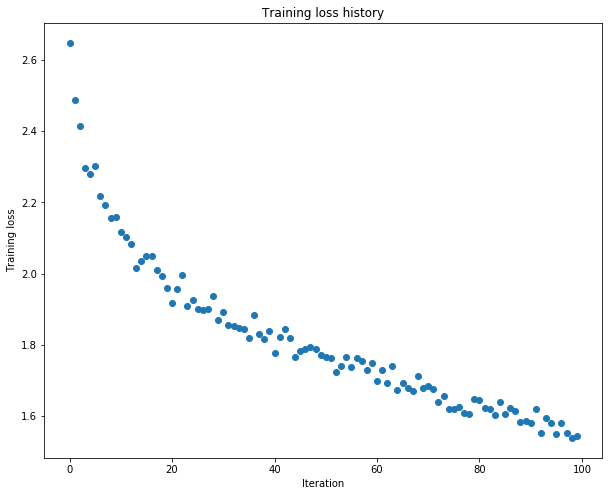

In [52]:
learning_rate = 5e-3
weight_scale = .05

model = FullyConnectedNet([200, 500, 500], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


(Iteration 1 / 100) loss: 2.438918
(Epoch 0 / 50) train acc: 0.194000; val_acc: 0.179000
(Epoch 1 / 50) train acc: 0.206000; val_acc: 0.196000
(Epoch 2 / 50) train acc: 0.208000; val_acc: 0.206000
(Epoch 3 / 50) train acc: 0.245000; val_acc: 0.217000
(Epoch 4 / 50) train acc: 0.270000; val_acc: 0.219000
(Epoch 5 / 50) train acc: 0.279000; val_acc: 0.251000
(Epoch 6 / 50) train acc: 0.288000; val_acc: 0.268000
(Epoch 7 / 50) train acc: 0.285000; val_acc: 0.269000
(Epoch 8 / 50) train acc: 0.288000; val_acc: 0.283000
(Epoch 9 / 50) train acc: 0.304000; val_acc: 0.297000
(Epoch 10 / 50) train acc: 0.324000; val_acc: 0.307000
(Epoch 11 / 50) train acc: 0.325000; val_acc: 0.306000
(Epoch 12 / 50) train acc: 0.332000; val_acc: 0.308000
(Epoch 13 / 50) train acc: 0.337000; val_acc: 0.312000
(Epoch 14 / 50) train acc: 0.351000; val_acc: 0.323000
(Epoch 15 / 50) train acc: 0.344000; val_acc: 0.336000
(Epoch 16 / 50) train acc: 0.374000; val_acc: 0.341000
(Epoch 17 / 50) train acc: 0.364000; val

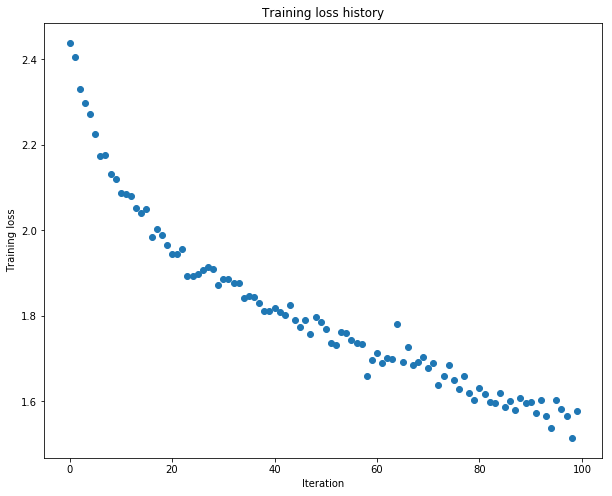

In [51]:
learning_rate = 5e-3
weight_scale = .05


model = FullyConnectedNet([200, 500, 200], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


(Iteration 1 / 100) loss: 2.346546
(Epoch 0 / 50) train acc: 0.145000; val_acc: 0.143000
(Epoch 1 / 50) train acc: 0.210000; val_acc: 0.175000
(Epoch 2 / 50) train acc: 0.231000; val_acc: 0.210000
(Epoch 3 / 50) train acc: 0.232000; val_acc: 0.211000
(Epoch 4 / 50) train acc: 0.226000; val_acc: 0.234000
(Epoch 5 / 50) train acc: 0.261000; val_acc: 0.249000
(Epoch 6 / 50) train acc: 0.232000; val_acc: 0.255000
(Epoch 7 / 50) train acc: 0.238000; val_acc: 0.260000
(Epoch 8 / 50) train acc: 0.254000; val_acc: 0.267000
(Epoch 9 / 50) train acc: 0.289000; val_acc: 0.277000
(Epoch 10 / 50) train acc: 0.281000; val_acc: 0.268000
(Epoch 11 / 50) train acc: 0.286000; val_acc: 0.274000
(Epoch 12 / 50) train acc: 0.300000; val_acc: 0.278000
(Epoch 13 / 50) train acc: 0.292000; val_acc: 0.274000
(Epoch 14 / 50) train acc: 0.292000; val_acc: 0.277000
(Epoch 15 / 50) train acc: 0.280000; val_acc: 0.278000
(Epoch 16 / 50) train acc: 0.315000; val_acc: 0.278000
(Epoch 17 / 50) train acc: 0.310000; val

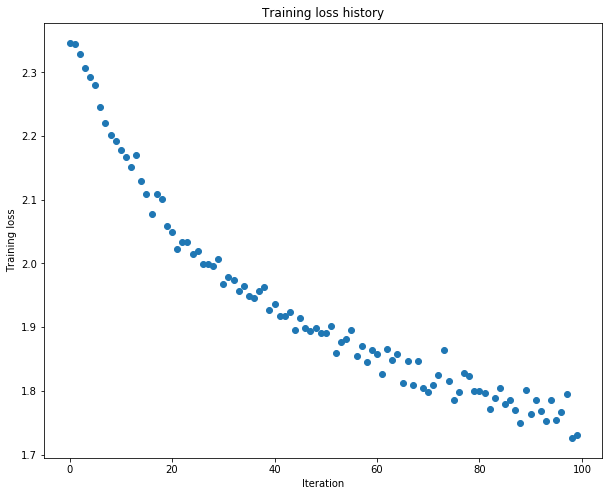

In [49]:
learning_rate = 5e-3
weight_scale = .05


model = FullyConnectedNet([100, 200, 100], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


(Iteration 1 / 100) loss: 2.356038
(Epoch 0 / 50) train acc: 0.108000; val_acc: 0.128000
(Epoch 1 / 50) train acc: 0.136000; val_acc: 0.134000
(Epoch 2 / 50) train acc: 0.105000; val_acc: 0.109000
(Epoch 3 / 50) train acc: 0.125000; val_acc: 0.122000
(Epoch 4 / 50) train acc: 0.099000; val_acc: 0.117000
(Epoch 5 / 50) train acc: 0.095000; val_acc: 0.121000
(Epoch 6 / 50) train acc: 0.138000; val_acc: 0.140000
(Epoch 7 / 50) train acc: 0.190000; val_acc: 0.210000
(Epoch 8 / 50) train acc: 0.199000; val_acc: 0.179000
(Epoch 9 / 50) train acc: 0.204000; val_acc: 0.202000
(Epoch 10 / 50) train acc: 0.240000; val_acc: 0.207000
(Epoch 11 / 50) train acc: 0.225000; val_acc: 0.200000
(Epoch 12 / 50) train acc: 0.185000; val_acc: 0.172000
(Epoch 13 / 50) train acc: 0.177000; val_acc: 0.180000
(Epoch 14 / 50) train acc: 0.236000; val_acc: 0.222000
(Epoch 15 / 50) train acc: 0.263000; val_acc: 0.227000
(Epoch 16 / 50) train acc: 0.234000; val_acc: 0.228000
(Epoch 17 / 50) train acc: 0.239000; val

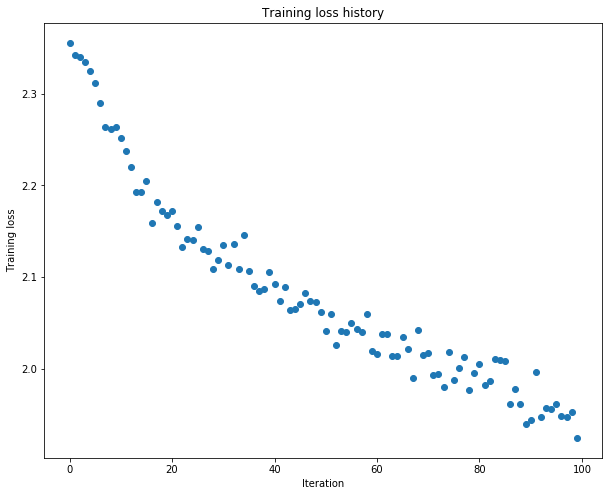

In [56]:
learning_rate = 1e-2 
weight_scale = .05


model = FullyConnectedNet([100, 100, 100, 100, 100], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=200,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 100) loss: 2.465452
(Epoch 0 / 50) train acc: 0.136000; val_acc: 0.141000
(Epoch 1 / 50) train acc: 0.179000; val_acc: 0.179000
(Epoch 2 / 50) train acc: 0.241000; val_acc: 0.233000
(Epoch 3 / 50) train acc: 0.289000; val_acc: 0.265000
(Epoch 4 / 50) train acc: 0.281000; val_acc: 0.262000
(Epoch 5 / 50) train acc: 0.289000; val_acc: 0.277000
(Epoch 6 / 50) train acc: 0.271000; val_acc: 0.286000
(Epoch 7 / 50) train acc: 0.299000; val_acc: 0.287000
(Epoch 8 / 50) train acc: 0.312000; val_acc: 0.302000
(Epoch 9 / 50) train acc: 0.320000; val_acc: 0.307000
(Epoch 10 / 50) train acc: 0.350000; val_acc: 0.309000
(Epoch 11 / 50) train acc: 0.318000; val_acc: 0.312000
(Epoch 12 / 50) train acc: 0.356000; val_acc: 0.325000
(Epoch 13 / 50) train acc: 0.379000; val_acc: 0.330000
(Epoch 14 / 50) train acc: 0.368000; val_acc: 0.327000
(Epoch 15 / 50) train acc: 0.383000; val_acc: 0.335000
(Epoch 16 / 50) train acc: 0.334000; val_acc: 0.342000
(Epoch 17 / 50) train acc: 0.360000; val

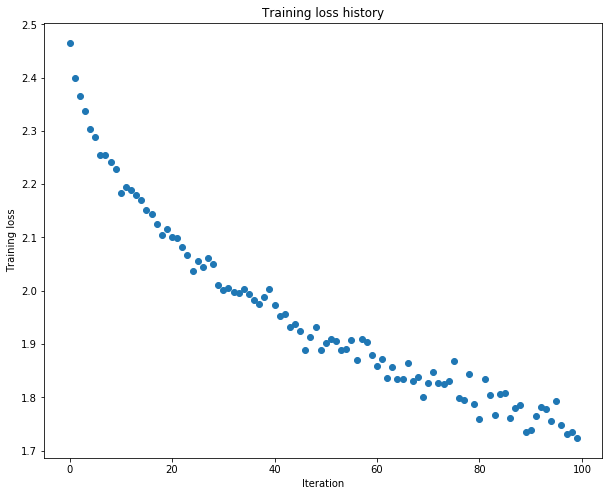

In [53]:
learning_rate = 1e-3 
weight_scale = .05


model = FullyConnectedNet([100, 200], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=200,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 200) loss: 2.367529
(Epoch 0 / 50) train acc: 0.203000; val_acc: 0.196000
(Epoch 1 / 50) train acc: 0.239000; val_acc: 0.241000
(Epoch 2 / 50) train acc: 0.278000; val_acc: 0.280000
(Epoch 3 / 50) train acc: 0.280000; val_acc: 0.281000
(Epoch 4 / 50) train acc: 0.281000; val_acc: 0.292000
(Epoch 5 / 50) train acc: 0.330000; val_acc: 0.313000
(Epoch 6 / 50) train acc: 0.342000; val_acc: 0.301000
(Epoch 7 / 50) train acc: 0.347000; val_acc: 0.305000
(Epoch 8 / 50) train acc: 0.353000; val_acc: 0.308000
(Epoch 9 / 50) train acc: 0.346000; val_acc: 0.313000
(Epoch 10 / 50) train acc: 0.344000; val_acc: 0.320000
(Epoch 11 / 50) train acc: 0.371000; val_acc: 0.331000
(Epoch 12 / 50) train acc: 0.388000; val_acc: 0.350000
(Epoch 13 / 50) train acc: 0.405000; val_acc: 0.358000
(Epoch 14 / 50) train acc: 0.374000; val_acc: 0.355000
(Epoch 15 / 50) train acc: 0.408000; val_acc: 0.361000
(Epoch 16 / 50) train acc: 0.415000; val_acc: 0.355000
(Epoch 17 / 50) train acc: 0.418000; val

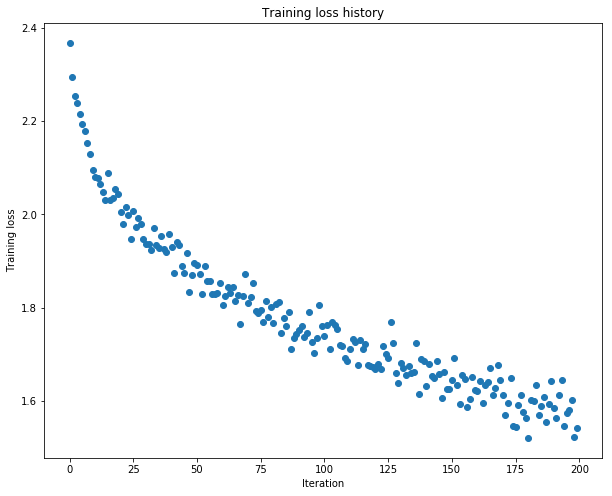

In [42]:
learning_rate = 5e-3 
weight_scale = .05


model = FullyConnectedNet([100, 100], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, small_data,
                  num_epochs=50, batch_size=1000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=500,
                  verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()



best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 480) loss: 2.360983
(Epoch 0 / 20) train acc: 0.104000; val_acc: 0.097000
(Iteration 11 / 480) loss: 2.343727
(Iteration 21 / 480) loss: 2.330855
(Epoch 1 / 20) train acc: 0.174000; val_acc: 0.145000
(Iteration 31 / 480) loss: 2.323465
(Iteration 41 / 480) loss: 2.314273
(Epoch 2 / 20) train acc: 0.182000; val_acc: 0.171000
(Iteration 51 / 480) loss: 2.272596
(Iteration 61 / 480) loss: 2.257846
(Iteration 71 / 480) loss: 2.242303
(Epoch 3 / 20) train acc: 0.162000; val_acc: 0.154000
(Iteration 81 / 480) loss: 2.219642
(Iteration 91 / 480) loss: 2.182963
(Epoch 4 / 20) train acc: 0.171000; val_acc: 0.136000
(Iteration 101 / 480) loss: 2.183297
(Iteration 111 / 480) loss: 2.153520
(Epoch 5 / 20) train acc: 0.198000; val_acc: 0.213000
(Iteration 121 / 480) loss: 2.149068
(Iteration 131 / 480) loss: 2.124175
(Iteration 141 / 480) loss: 2.110395
(Epoch 6 / 20) train acc: 0.223000; val_acc: 0.216000
(Iteration 151 / 480) loss: 2.087495
(Iteration 161 / 480) loss: 2.088795
(Epo

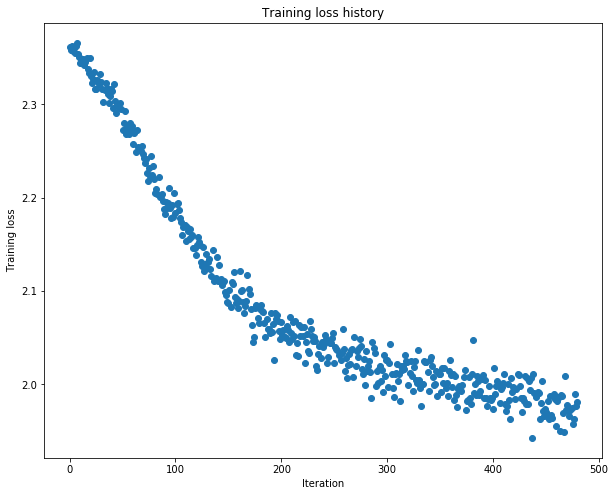

In [62]:
learning_rate = 1e-3 
weight_scale = .05


model = FullyConnectedNet([100, 100, 100, 100, 100], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, data,
                  num_epochs=20, batch_size=2000,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                 verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [67]:
learning_rate = 1e-3
weight_scale = .05


model = FullyConnectedNet([100, 100, 100, 100, 100], dropout=0.5, use_batchnorm=True, weight_scale=5e-2)

solver = Solver(model, data,
                  num_epochs=20, batch_size=250,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': learning_rate
                  },
                 verbose=True)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3920) loss: 2.337854
(Epoch 0 / 20) train acc: 0.084000; val_acc: 0.085000
(Iteration 11 / 3920) loss: 2.350307
(Iteration 21 / 3920) loss: 2.346908
(Iteration 31 / 3920) loss: 2.334077
(Iteration 41 / 3920) loss: 2.318992
(Iteration 51 / 3920) loss: 2.304697
(Iteration 61 / 3920) loss: 2.325158
(Iteration 71 / 3920) loss: 2.266476
(Iteration 81 / 3920) loss: 2.299668
(Iteration 91 / 3920) loss: 2.250345
(Iteration 101 / 3920) loss: 2.261249
(Iteration 111 / 3920) loss: 2.253972
(Iteration 121 / 3920) loss: 2.225242
(Iteration 131 / 3920) loss: 2.218673
(Iteration 141 / 3920) loss: 2.231999
(Iteration 151 / 3920) loss: 2.207039
(Iteration 161 / 3920) loss: 2.190317
(Iteration 171 / 3920) loss: 2.179856
(Iteration 181 / 3920) loss: 2.156358
(Iteration 191 / 3920) loss: 2.196349
(Epoch 1 / 20) train acc: 0.193000; val_acc: 0.213000
(Iteration 201 / 3920) loss: 2.175204
(Iteration 211 / 3920) loss: 2.157582
(Iteration 221 / 3920) loss: 2.152925
(Iteration 231 / 3920) loss: 

KeyboardInterrupt: 

(Iteration 1 / 200) loss: 1.809202
(Epoch 50 / 50) train acc: 0.448000; val_acc: 0.363000
(Epoch 51 / 50) train acc: 0.414000; val_acc: 0.355000
(Epoch 52 / 50) train acc: 0.439000; val_acc: 0.339000
(Epoch 53 / 50) train acc: 0.423000; val_acc: 0.331000
(Epoch 54 / 50) train acc: 0.464000; val_acc: 0.338000
(Epoch 55 / 50) train acc: 0.452000; val_acc: 0.344000
(Epoch 56 / 50) train acc: 0.439000; val_acc: 0.349000
(Epoch 57 / 50) train acc: 0.455000; val_acc: 0.332000
(Epoch 58 / 50) train acc: 0.409000; val_acc: 0.333000
(Epoch 59 / 50) train acc: 0.478000; val_acc: 0.345000
(Epoch 60 / 50) train acc: 0.446000; val_acc: 0.356000
(Epoch 61 / 50) train acc: 0.462000; val_acc: 0.349000
(Epoch 62 / 50) train acc: 0.461000; val_acc: 0.358000
(Epoch 63 / 50) train acc: 0.434000; val_acc: 0.361000
(Epoch 64 / 50) train acc: 0.457000; val_acc: 0.331000
(Epoch 65 / 50) train acc: 0.443000; val_acc: 0.362000
(Epoch 66 / 50) train acc: 0.463000; val_acc: 0.353000
(Epoch 67 / 50) train acc: 0.4

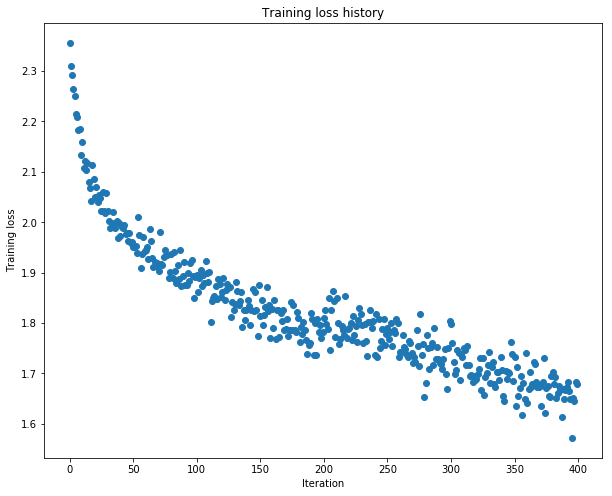

In [40]:
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


In [68]:
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3
                },
                verbose=True)

solver.train()


(Iteration 1 / 3820) loss: 6.808927
(Epoch 0 / 20) train acc: 0.166000; val_acc: 0.161000
(Iteration 11 / 3820) loss: 6.068185
(Iteration 21 / 3820) loss: 5.572144
(Iteration 31 / 3820) loss: 5.098485
(Iteration 41 / 3820) loss: 4.875071
(Iteration 51 / 3820) loss: 4.544911
(Iteration 61 / 3820) loss: 4.097127
(Iteration 71 / 3820) loss: 3.785479
(Iteration 81 / 3820) loss: 3.577010
(Iteration 91 / 3820) loss: 3.453361
(Iteration 101 / 3820) loss: 3.153370
(Iteration 111 / 3820) loss: 3.165943
(Iteration 121 / 3820) loss: 2.967527
(Iteration 131 / 3820) loss: 2.775026
(Iteration 141 / 3820) loss: 2.682420
(Iteration 151 / 3820) loss: 2.746877
(Iteration 161 / 3820) loss: 2.494838
(Iteration 171 / 3820) loss: 2.432425
(Iteration 181 / 3820) loss: 2.387022
(Iteration 191 / 3820) loss: 2.355102
(Epoch 1 / 20) train acc: 0.461000; val_acc: 0.451000
(Iteration 201 / 3820) loss: 2.304203
(Iteration 211 / 3820) loss: 2.235152
(Iteration 221 / 3820) loss: 2.136045
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 1.620313
(Iteration 1991 / 3820) loss: 1.436653
(Iteration 2001 / 3820) loss: 1.570238
(Iteration 2011 / 3820) loss: 1.651180
(Iteration 2021 / 3820) loss: 1.646172
(Iteration 2031 / 3820) loss: 1.483774
(Iteration 2041 / 3820) loss: 1.452958
(Iteration 2051 / 3820) loss: 1.651944
(Iteration 2061 / 3820) loss: 1.553205
(Iteration 2071 / 3820) loss: 1.628547
(Iteration 2081 / 3820) loss: 1.607449
(Iteration 2091 / 3820) loss: 1.571736
(Iteration 2101 / 3820) loss: 1.611154
(Epoch 11 / 20) train acc: 0.542000; val_acc: 0.495000
(Iteration 2111 / 3820) loss: 1.459121
(Iteration 2121 / 3820) loss: 1.484175
(Iteration 2131 / 3820) loss: 1.586484
(Iteration 2141 / 3820) loss: 1.591755
(Iteration 2151 / 3820) loss: 1.611946
(Iteration 2161 / 3820) loss: 1.609838
(Iteration 2171 / 3820) loss: 1.517083
(Iteration 2181 / 3820) loss: 1.468812
(Iteration 2191 / 3820) loss: 1.668900
(Iteration 2201 / 3820) loss: 1.615784
(Iteration 2211 / 3820) loss: 1.605649
(Iteratio

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [69]:
best_model = model

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.515
Test set accuracy:  0.513


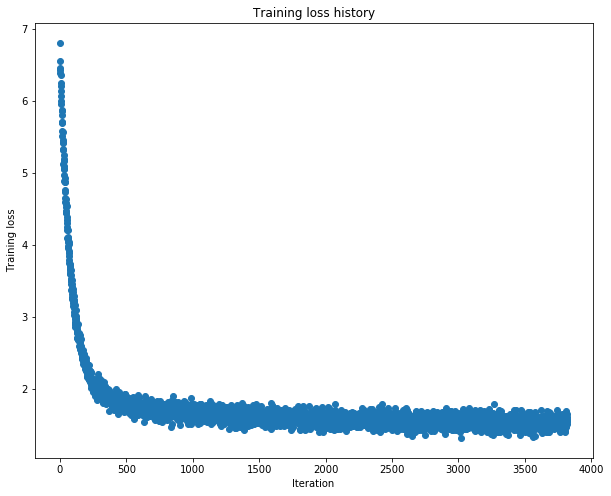

In [70]:
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.701633
(Epoch 0 / 20) train acc: 0.107000; val_acc: 0.086000
(Iteration 11 / 3820) loss: 6.164261
(Iteration 21 / 3820) loss: 5.537027
(Iteration 31 / 3820) loss: 5.096480
(Iteration 41 / 3820) loss: 4.622314
(Iteration 51 / 3820) loss: 4.246094
(Iteration 61 / 3820) loss: 3.925076
(Iteration 71 / 3820) loss: 3.711280
(Iteration 81 / 3820) loss: 3.426585
(Iteration 91 / 3820) loss: 3.266602
(Iteration 101 / 3820) loss: 3.132762
(Iteration 111 / 3820) loss: 3.036965
(Iteration 121 / 3820) loss: 2.936352
(Iteration 131 / 3820) loss: 2.838247
(Iteration 141 / 3820) loss: 2.778457
(Iteration 151 / 3820) loss: 2.729973
(Iteration 161 / 3820) loss: 2.677949
(Iteration 171 / 3820) loss: 2.647221
(Iteration 181 / 3820) loss: 2.599572
(Iteration 191 / 3820) loss: 2.577616
(Epoch 1 / 20) train acc: 0.139000; val_acc: 0.148000
(Iteration 201 / 3820) loss: 2.568472
(Iteration 211 / 3820) loss: 2.500667
(Iteration 221 / 3820) loss: 2.468634
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 2.266297
(Iteration 1991 / 3820) loss: 2.198756
(Iteration 2001 / 3820) loss: 2.133092
(Iteration 2011 / 3820) loss: 2.142277
(Iteration 2021 / 3820) loss: 2.140713
(Iteration 2031 / 3820) loss: 2.174993
(Iteration 2041 / 3820) loss: 2.100101
(Iteration 2051 / 3820) loss: 2.217947
(Iteration 2061 / 3820) loss: 2.158963
(Iteration 2071 / 3820) loss: 2.186408
(Iteration 2081 / 3820) loss: 2.137031
(Iteration 2091 / 3820) loss: 2.128120
(Iteration 2101 / 3820) loss: 2.140866
(Epoch 11 / 20) train acc: 0.238000; val_acc: 0.244000
(Iteration 2111 / 3820) loss: 2.165996
(Iteration 2121 / 3820) loss: 2.185817
(Iteration 2131 / 3820) loss: 2.132971
(Iteration 2141 / 3820) loss: 2.110914
(Iteration 2151 / 3820) loss: 2.108882
(Iteration 2161 / 3820) loss: 2.197159
(Iteration 2171 / 3820) loss: 2.097742
(Iteration 2181 / 3820) loss: 2.234739
(Iteration 2191 / 3820) loss: 2.156910
(Iteration 2201 / 3820) loss: 2.176884
(Iteration 2211 / 3820) loss: 2.252052
(Iteratio

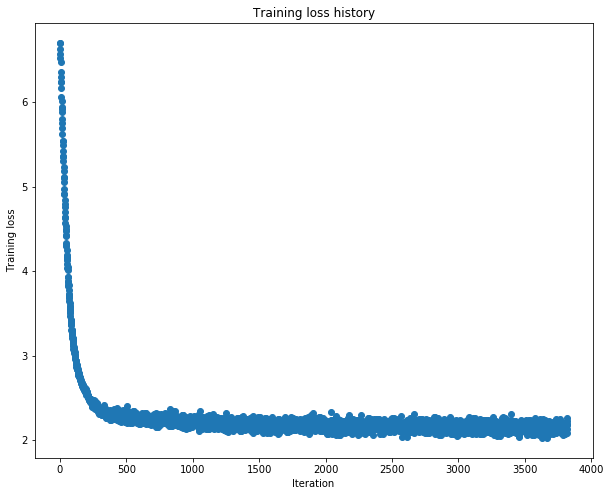

In [71]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, dropout=0.5, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.745174
(Epoch 0 / 20) train acc: 0.096000; val_acc: 0.105000
(Iteration 11 / 3820) loss: 6.055684
(Iteration 21 / 3820) loss: 5.353248
(Iteration 31 / 3820) loss: 4.921683
(Iteration 41 / 3820) loss: 4.413654
(Iteration 51 / 3820) loss: 3.990217
(Iteration 61 / 3820) loss: 3.640940
(Iteration 71 / 3820) loss: 3.538962
(Iteration 81 / 3820) loss: 3.160591
(Iteration 91 / 3820) loss: 3.068062
(Iteration 101 / 3820) loss: 2.771816
(Iteration 111 / 3820) loss: 2.722749
(Iteration 121 / 3820) loss: 2.738902
(Iteration 131 / 3820) loss: 2.579323
(Iteration 141 / 3820) loss: 2.538624
(Iteration 151 / 3820) loss: 2.314095
(Iteration 161 / 3820) loss: 2.272975
(Iteration 171 / 3820) loss: 2.274133
(Iteration 181 / 3820) loss: 2.164949
(Iteration 191 / 3820) loss: 2.031213
(Epoch 1 / 20) train acc: 0.469000; val_acc: 0.466000
(Iteration 201 / 3820) loss: 2.070499
(Iteration 211 / 3820) loss: 2.039120
(Iteration 221 / 3820) loss: 2.010056
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 1.594731
(Iteration 1991 / 3820) loss: 1.500126
(Iteration 2001 / 3820) loss: 1.577945
(Iteration 2011 / 3820) loss: 1.614336
(Iteration 2021 / 3820) loss: 1.535076
(Iteration 2031 / 3820) loss: 1.461751
(Iteration 2041 / 3820) loss: 1.493923
(Iteration 2051 / 3820) loss: 1.656300
(Iteration 2061 / 3820) loss: 1.648859
(Iteration 2071 / 3820) loss: 1.542502
(Iteration 2081 / 3820) loss: 1.542802
(Iteration 2091 / 3820) loss: 1.595591
(Iteration 2101 / 3820) loss: 1.463869
(Epoch 11 / 20) train acc: 0.504000; val_acc: 0.494000
(Iteration 2111 / 3820) loss: 1.509880
(Iteration 2121 / 3820) loss: 1.578640
(Iteration 2131 / 3820) loss: 1.491072
(Iteration 2141 / 3820) loss: 1.485660
(Iteration 2151 / 3820) loss: 1.607006
(Iteration 2161 / 3820) loss: 1.608415
(Iteration 2171 / 3820) loss: 1.561216
(Iteration 2181 / 3820) loss: 1.567495
(Iteration 2191 / 3820) loss: 1.626816
(Iteration 2201 / 3820) loss: 1.552936
(Iteration 2211 / 3820) loss: 1.562225
(Iteratio

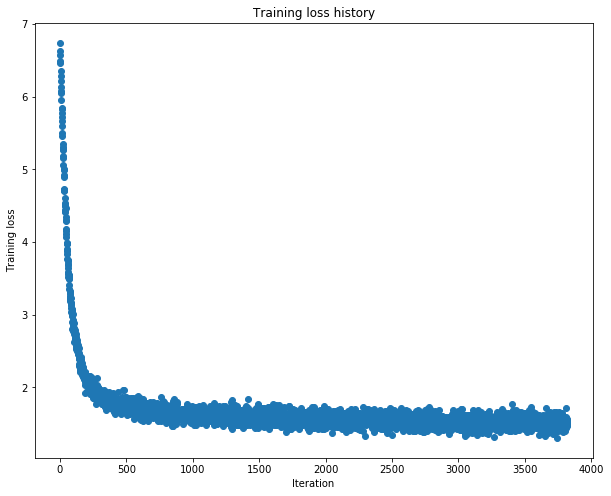

In [72]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.694304
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.108000
(Iteration 11 / 3820) loss: 6.298175
(Iteration 21 / 3820) loss: 5.949485
(Iteration 31 / 3820) loss: 5.634666
(Iteration 41 / 3820) loss: 5.228226
(Iteration 51 / 3820) loss: 5.056763
(Iteration 61 / 3820) loss: 4.780824
(Iteration 71 / 3820) loss: 4.603195
(Iteration 81 / 3820) loss: 4.401970
(Iteration 91 / 3820) loss: 4.138414
(Iteration 101 / 3820) loss: 4.036865
(Iteration 111 / 3820) loss: 3.951115
(Iteration 121 / 3820) loss: 3.700489
(Iteration 131 / 3820) loss: 3.594326
(Iteration 141 / 3820) loss: 3.420559
(Iteration 151 / 3820) loss: 3.439086
(Iteration 161 / 3820) loss: 3.463192
(Iteration 171 / 3820) loss: 3.296716
(Iteration 181 / 3820) loss: 3.067903
(Iteration 191 / 3820) loss: 3.004290
(Epoch 1 / 20) train acc: 0.477000; val_acc: 0.444000
(Iteration 201 / 3820) loss: 2.939638
(Iteration 211 / 3820) loss: 2.922771
(Iteration 221 / 3820) loss: 2.806359
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 1.429192
(Iteration 1991 / 3820) loss: 1.341910
(Iteration 2001 / 3820) loss: 1.422097
(Iteration 2011 / 3820) loss: 1.343583
(Iteration 2021 / 3820) loss: 1.440788
(Iteration 2031 / 3820) loss: 1.514814
(Iteration 2041 / 3820) loss: 1.252817
(Iteration 2051 / 3820) loss: 1.496753
(Iteration 2061 / 3820) loss: 1.303557
(Iteration 2071 / 3820) loss: 1.348345
(Iteration 2081 / 3820) loss: 1.403354
(Iteration 2091 / 3820) loss: 1.441849
(Iteration 2101 / 3820) loss: 1.389455
(Epoch 11 / 20) train acc: 0.571000; val_acc: 0.505000
(Iteration 2111 / 3820) loss: 1.380152
(Iteration 2121 / 3820) loss: 1.465573
(Iteration 2131 / 3820) loss: 1.551483
(Iteration 2141 / 3820) loss: 1.418405
(Iteration 2151 / 3820) loss: 1.377466
(Iteration 2161 / 3820) loss: 1.413844
(Iteration 2171 / 3820) loss: 1.550088
(Iteration 2181 / 3820) loss: 1.363622
(Iteration 2191 / 3820) loss: 1.447394
(Iteration 2201 / 3820) loss: 1.347913
(Iteration 2211 / 3820) loss: 1.465175
(Iteratio

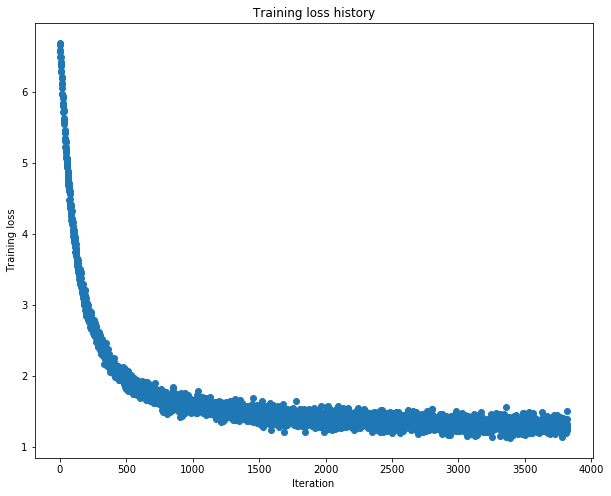

In [73]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.713889
(Epoch 0 / 20) train acc: 0.122000; val_acc: 0.128000
(Iteration 11 / 3820) loss: 6.625870
(Iteration 21 / 3820) loss: 6.496312
(Iteration 31 / 3820) loss: 6.427361
(Iteration 41 / 3820) loss: 6.343554
(Iteration 51 / 3820) loss: 6.258982
(Iteration 61 / 3820) loss: 6.161385
(Iteration 71 / 3820) loss: 6.074334
(Iteration 81 / 3820) loss: 6.010856
(Iteration 91 / 3820) loss: 5.955311
(Iteration 101 / 3820) loss: 5.930723
(Iteration 111 / 3820) loss: 5.838608
(Iteration 121 / 3820) loss: 5.731138
(Iteration 131 / 3820) loss: 5.713872
(Iteration 141 / 3820) loss: 5.684296
(Iteration 151 / 3820) loss: 5.618836
(Iteration 161 / 3820) loss: 5.527702
(Iteration 171 / 3820) loss: 5.554219
(Iteration 181 / 3820) loss: 5.384353
(Iteration 191 / 3820) loss: 5.427953
(Epoch 1 / 20) train acc: 0.345000; val_acc: 0.348000
(Iteration 201 / 3820) loss: 5.337138
(Iteration 211 / 3820) loss: 5.308155
(Iteration 221 / 3820) loss: 5.220195
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 2.202695
(Iteration 1991 / 3820) loss: 2.150015
(Iteration 2001 / 3820) loss: 2.358781
(Iteration 2011 / 3820) loss: 2.113541
(Iteration 2021 / 3820) loss: 2.254987
(Iteration 2031 / 3820) loss: 2.180903
(Iteration 2041 / 3820) loss: 2.253446
(Iteration 2051 / 3820) loss: 2.315852
(Iteration 2061 / 3820) loss: 2.243814
(Iteration 2071 / 3820) loss: 2.221293
(Iteration 2081 / 3820) loss: 2.146102
(Iteration 2091 / 3820) loss: 2.127775
(Iteration 2101 / 3820) loss: 2.228164
(Epoch 11 / 20) train acc: 0.608000; val_acc: 0.507000
(Iteration 2111 / 3820) loss: 2.269607
(Iteration 2121 / 3820) loss: 2.185793
(Iteration 2131 / 3820) loss: 2.055588
(Iteration 2141 / 3820) loss: 2.148130
(Iteration 2151 / 3820) loss: 2.201173
(Iteration 2161 / 3820) loss: 2.093823
(Iteration 2171 / 3820) loss: 2.231469
(Iteration 2181 / 3820) loss: 2.124114
(Iteration 2191 / 3820) loss: 2.209858
(Iteration 2201 / 3820) loss: 2.072137
(Iteration 2211 / 3820) loss: 2.092417
(Iteratio

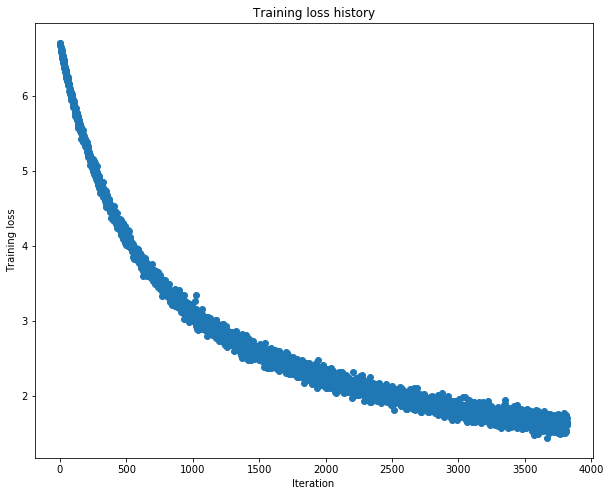

In [74]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 12.154403
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.101000
(Iteration 11 / 3820) loss: 11.520832
(Iteration 21 / 3820) loss: 10.918713
(Iteration 31 / 3820) loss: 10.287334
(Iteration 41 / 3820) loss: 9.653263
(Iteration 51 / 3820) loss: 9.140096
(Iteration 61 / 3820) loss: 8.685728
(Iteration 71 / 3820) loss: 8.216616
(Iteration 81 / 3820) loss: 7.734666
(Iteration 91 / 3820) loss: 7.389666
(Iteration 101 / 3820) loss: 6.939475
(Iteration 111 / 3820) loss: 6.598895
(Iteration 121 / 3820) loss: 6.331229
(Iteration 131 / 3820) loss: 6.013638
(Iteration 141 / 3820) loss: 5.683730
(Iteration 151 / 3820) loss: 5.452637
(Iteration 161 / 3820) loss: 5.259973
(Iteration 171 / 3820) loss: 5.011179
(Iteration 181 / 3820) loss: 4.790180
(Iteration 191 / 3820) loss: 4.638317
(Epoch 1 / 20) train acc: 0.206000; val_acc: 0.212000
(Iteration 201 / 3820) loss: 4.460460
(Iteration 211 / 3820) loss: 4.312451
(Iteration 221 / 3820) loss: 4.090833
(Iteration 231 / 3820) lo

(Iteration 1981 / 3820) loss: 2.149906
(Iteration 1991 / 3820) loss: 2.101750
(Iteration 2001 / 3820) loss: 2.096141
(Iteration 2011 / 3820) loss: 2.110758
(Iteration 2021 / 3820) loss: 2.129632
(Iteration 2031 / 3820) loss: 2.154086
(Iteration 2041 / 3820) loss: 2.058362
(Iteration 2051 / 3820) loss: 2.125291
(Iteration 2061 / 3820) loss: 2.116417
(Iteration 2071 / 3820) loss: 2.212082
(Iteration 2081 / 3820) loss: 2.073378
(Iteration 2091 / 3820) loss: 2.188327
(Iteration 2101 / 3820) loss: 2.085738
(Epoch 11 / 20) train acc: 0.296000; val_acc: 0.276000
(Iteration 2111 / 3820) loss: 2.102641
(Iteration 2121 / 3820) loss: 2.110213
(Iteration 2131 / 3820) loss: 2.087989
(Iteration 2141 / 3820) loss: 2.108070
(Iteration 2151 / 3820) loss: 2.119559
(Iteration 2161 / 3820) loss: 2.109655
(Iteration 2171 / 3820) loss: 2.102410
(Iteration 2181 / 3820) loss: 2.065298
(Iteration 2191 / 3820) loss: 2.138200
(Iteration 2201 / 3820) loss: 2.126116
(Iteration 2211 / 3820) loss: 2.139503
(Iteratio

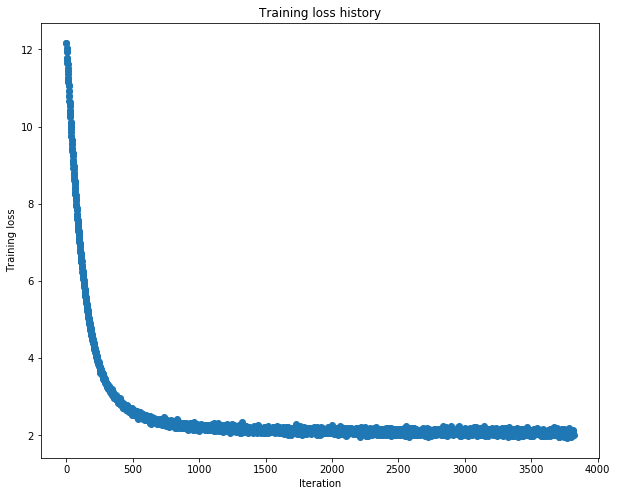

In [75]:
model = FullyConnectedNet([200, 200, 200, 200, 200], use_batchnorm=True, dropout=0.5, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 12.112421
(Epoch 0 / 20) train acc: 0.097000; val_acc: 0.110000
(Iteration 11 / 3820) loss: 10.935802
(Iteration 21 / 3820) loss: 9.635273
(Iteration 31 / 3820) loss: 8.523247
(Iteration 41 / 3820) loss: 7.576271
(Iteration 51 / 3820) loss: 6.731761
(Iteration 61 / 3820) loss: 6.061845
(Iteration 71 / 3820) loss: 5.473648
(Iteration 81 / 3820) loss: 4.918196
(Iteration 91 / 3820) loss: 4.550218
(Iteration 101 / 3820) loss: 4.239177
(Iteration 111 / 3820) loss: 3.985926
(Iteration 121 / 3820) loss: 3.752815
(Iteration 131 / 3820) loss: 3.501617
(Iteration 141 / 3820) loss: 3.375228
(Iteration 151 / 3820) loss: 3.258276
(Iteration 161 / 3820) loss: 3.165683
(Iteration 171 / 3820) loss: 3.075150
(Iteration 181 / 3820) loss: 2.987045
(Iteration 191 / 3820) loss: 2.892669
(Epoch 1 / 20) train acc: 0.184000; val_acc: 0.218000
(Iteration 201 / 3820) loss: 2.905346
(Iteration 211 / 3820) loss: 2.788031
(Iteration 221 / 3820) loss: 2.740250
(Iteration 231 / 3820) loss

(Iteration 1981 / 3820) loss: 2.201823
(Iteration 1991 / 3820) loss: 2.194686
(Iteration 2001 / 3820) loss: 2.113431
(Iteration 2011 / 3820) loss: 2.200943
(Iteration 2021 / 3820) loss: 2.170316
(Iteration 2031 / 3820) loss: 2.152802
(Iteration 2041 / 3820) loss: 2.159442
(Iteration 2051 / 3820) loss: 2.268428
(Iteration 2061 / 3820) loss: 2.221078
(Iteration 2071 / 3820) loss: 2.200622
(Iteration 2081 / 3820) loss: 2.229876
(Iteration 2091 / 3820) loss: 2.198043
(Iteration 2101 / 3820) loss: 2.273479
(Epoch 11 / 20) train acc: 0.289000; val_acc: 0.274000
(Iteration 2111 / 3820) loss: 2.143727
(Iteration 2121 / 3820) loss: 2.138673
(Iteration 2131 / 3820) loss: 2.261136
(Iteration 2141 / 3820) loss: 2.148936
(Iteration 2151 / 3820) loss: 2.249193
(Iteration 2161 / 3820) loss: 2.201029
(Iteration 2171 / 3820) loss: 2.155494
(Iteration 2181 / 3820) loss: 2.221981
(Iteration 2191 / 3820) loss: 2.193182
(Iteration 2201 / 3820) loss: 2.147209
(Iteration 2211 / 3820) loss: 2.203703
(Iteratio

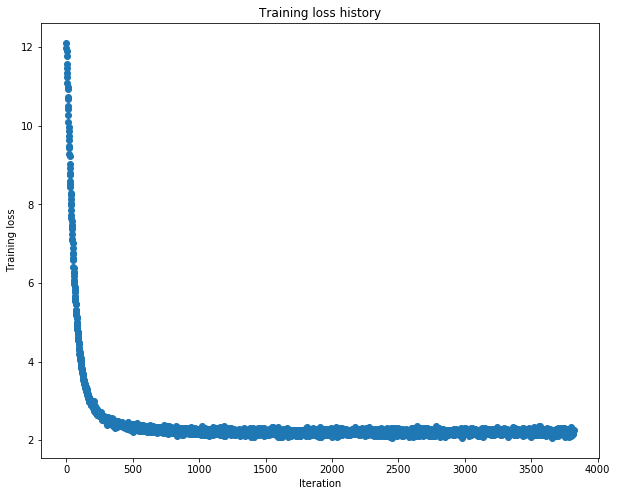

In [76]:
model = FullyConnectedNet([200, 200, 200, 200, 200], use_batchnorm=True, dropout=0.5, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.708936
(Epoch 0 / 20) train acc: 0.104000; val_acc: 0.101000
(Iteration 11 / 3820) loss: 6.608345
(Iteration 21 / 3820) loss: 6.583213
(Iteration 31 / 3820) loss: 6.487409
(Iteration 41 / 3820) loss: 6.430236
(Iteration 51 / 3820) loss: 6.349495
(Iteration 61 / 3820) loss: 6.307388
(Iteration 71 / 3820) loss: 6.250606
(Iteration 81 / 3820) loss: 6.166886
(Iteration 91 / 3820) loss: 6.123048
(Iteration 101 / 3820) loss: 6.057793
(Iteration 111 / 3820) loss: 5.996450
(Iteration 121 / 3820) loss: 5.946676
(Iteration 131 / 3820) loss: 5.871223
(Iteration 141 / 3820) loss: 5.813611
(Iteration 151 / 3820) loss: 5.750859
(Iteration 161 / 3820) loss: 5.725203
(Iteration 171 / 3820) loss: 5.671313
(Iteration 181 / 3820) loss: 5.608622
(Iteration 191 / 3820) loss: 5.544930
(Epoch 1 / 20) train acc: 0.164000; val_acc: 0.151000
(Iteration 201 / 3820) loss: 5.530932
(Iteration 211 / 3820) loss: 5.438946
(Iteration 221 / 3820) loss: 5.385485
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 2.443338
(Iteration 1991 / 3820) loss: 2.349204
(Iteration 2001 / 3820) loss: 2.351123
(Iteration 2011 / 3820) loss: 2.377555
(Iteration 2021 / 3820) loss: 2.402849
(Iteration 2031 / 3820) loss: 2.364794
(Iteration 2041 / 3820) loss: 2.418545
(Iteration 2051 / 3820) loss: 2.343448
(Iteration 2061 / 3820) loss: 2.384324
(Iteration 2071 / 3820) loss: 2.366356
(Iteration 2081 / 3820) loss: 2.374041
(Iteration 2091 / 3820) loss: 2.400941
(Iteration 2101 / 3820) loss: 2.338845
(Epoch 11 / 20) train acc: 0.236000; val_acc: 0.233000
(Iteration 2111 / 3820) loss: 2.346053
(Iteration 2121 / 3820) loss: 2.385345
(Iteration 2131 / 3820) loss: 2.387668
(Iteration 2141 / 3820) loss: 2.311233
(Iteration 2151 / 3820) loss: 2.305502
(Iteration 2161 / 3820) loss: 2.258499
(Iteration 2171 / 3820) loss: 2.326638
(Iteration 2181 / 3820) loss: 2.344450
(Iteration 2191 / 3820) loss: 2.305648
(Iteration 2201 / 3820) loss: 2.299442
(Iteration 2211 / 3820) loss: 2.266189
(Iteratio

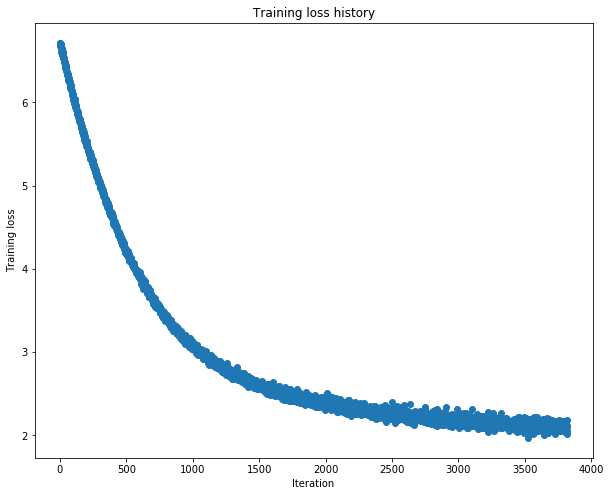

In [77]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, dropout=0.3, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 6.759743
(Epoch 0 / 20) train acc: 0.088000; val_acc: 0.093000
(Iteration 11 / 3820) loss: 6.670433
(Iteration 21 / 3820) loss: 6.576756
(Iteration 31 / 3820) loss: 6.520813
(Iteration 41 / 3820) loss: 6.431964
(Iteration 51 / 3820) loss: 6.388553
(Iteration 61 / 3820) loss: 6.339524
(Iteration 71 / 3820) loss: 6.247411
(Iteration 81 / 3820) loss: 6.244065
(Iteration 91 / 3820) loss: 6.213947
(Iteration 101 / 3820) loss: 6.123437
(Iteration 111 / 3820) loss: 6.084371
(Iteration 121 / 3820) loss: 6.048283
(Iteration 131 / 3820) loss: 5.978960
(Iteration 141 / 3820) loss: 5.907002
(Iteration 151 / 3820) loss: 5.885394
(Iteration 161 / 3820) loss: 5.824696
(Iteration 171 / 3820) loss: 5.791523
(Iteration 181 / 3820) loss: 5.728044
(Iteration 191 / 3820) loss: 5.648991
(Epoch 1 / 20) train acc: 0.138000; val_acc: 0.123000
(Iteration 201 / 3820) loss: 5.655253
(Iteration 211 / 3820) loss: 5.592164
(Iteration 221 / 3820) loss: 5.527847
(Iteration 231 / 3820) loss: 

(Iteration 1981 / 3820) loss: 2.473732
(Iteration 1991 / 3820) loss: 2.444282
(Iteration 2001 / 3820) loss: 2.474795
(Iteration 2011 / 3820) loss: 2.436411
(Iteration 2021 / 3820) loss: 2.437473
(Iteration 2031 / 3820) loss: 2.512058
(Iteration 2041 / 3820) loss: 2.487114
(Iteration 2051 / 3820) loss: 2.454045
(Iteration 2061 / 3820) loss: 2.449948
(Iteration 2071 / 3820) loss: 2.415937
(Iteration 2081 / 3820) loss: 2.440816
(Iteration 2091 / 3820) loss: 2.451705
(Iteration 2101 / 3820) loss: 2.437677
(Epoch 11 / 20) train acc: 0.235000; val_acc: 0.255000
(Iteration 2111 / 3820) loss: 2.379319
(Iteration 2121 / 3820) loss: 2.411278
(Iteration 2131 / 3820) loss: 2.448182
(Iteration 2141 / 3820) loss: 2.370423
(Iteration 2151 / 3820) loss: 2.423755
(Iteration 2161 / 3820) loss: 2.412718
(Iteration 2171 / 3820) loss: 2.433140
(Iteration 2181 / 3820) loss: 2.423507
(Iteration 2191 / 3820) loss: 2.368416
(Iteration 2201 / 3820) loss: 2.401085
(Iteration 2211 / 3820) loss: 2.380857
(Iteratio

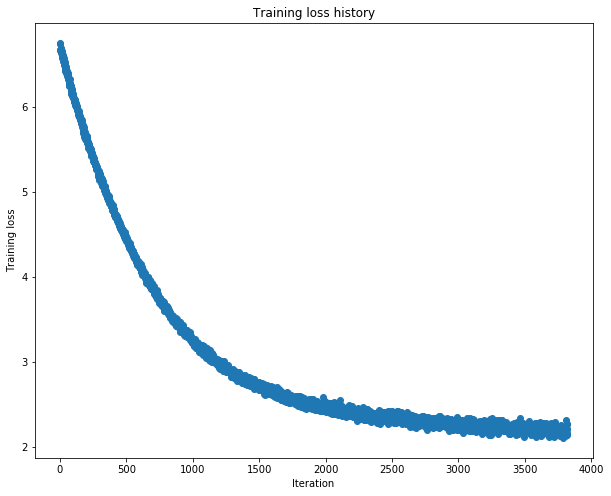

In [78]:
model = FullyConnectedNet([100, 100, 100, 100, 100], use_batchnorm=True, dropout=0.5, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 3820) loss: 12.349662
(Epoch 0 / 20) train acc: 0.088000; val_acc: 0.078000
(Iteration 11 / 3820) loss: 12.067578
(Iteration 21 / 3820) loss: 12.162049
(Iteration 31 / 3820) loss: 12.013720
(Iteration 41 / 3820) loss: 11.960536
(Iteration 51 / 3820) loss: 11.760501
(Iteration 61 / 3820) loss: 11.701565
(Iteration 71 / 3820) loss: 11.637826
(Iteration 81 / 3820) loss: 11.513571
(Iteration 91 / 3820) loss: 11.480112
(Iteration 101 / 3820) loss: 11.342948
(Iteration 111 / 3820) loss: 11.202119
(Iteration 121 / 3820) loss: 11.194660
(Iteration 131 / 3820) loss: 11.042296
(Iteration 141 / 3820) loss: 10.942454
(Iteration 151 / 3820) loss: 10.898441
(Iteration 161 / 3820) loss: 10.739188
(Iteration 171 / 3820) loss: 10.704448
(Iteration 181 / 3820) loss: 10.616313
(Iteration 191 / 3820) loss: 10.479757
(Epoch 1 / 20) train acc: 0.111000; val_acc: 0.109000
(Iteration 201 / 3820) loss: 10.484853
(Iteration 211 / 3820) loss: 10.385461
(Iteration 221 / 3820) loss: 10.322502
(Itera

(Iteration 1971 / 3820) loss: 3.444349
(Iteration 1981 / 3820) loss: 3.420865
(Iteration 1991 / 3820) loss: 3.375254
(Iteration 2001 / 3820) loss: 3.382018
(Iteration 2011 / 3820) loss: 3.368406
(Iteration 2021 / 3820) loss: 3.383438
(Iteration 2031 / 3820) loss: 3.385190
(Iteration 2041 / 3820) loss: 3.422737
(Iteration 2051 / 3820) loss: 3.333600
(Iteration 2061 / 3820) loss: 3.299969
(Iteration 2071 / 3820) loss: 3.295906
(Iteration 2081 / 3820) loss: 3.368555
(Iteration 2091 / 3820) loss: 3.319791
(Iteration 2101 / 3820) loss: 3.250866
(Epoch 11 / 20) train acc: 0.154000; val_acc: 0.162000
(Iteration 2111 / 3820) loss: 3.218227
(Iteration 2121 / 3820) loss: 3.203046
(Iteration 2131 / 3820) loss: 3.244042
(Iteration 2141 / 3820) loss: 3.215772
(Iteration 2151 / 3820) loss: 3.241810
(Iteration 2161 / 3820) loss: 3.180778
(Iteration 2171 / 3820) loss: 3.203246
(Iteration 2181 / 3820) loss: 3.181878
(Iteration 2191 / 3820) loss: 3.156694
(Iteration 2201 / 3820) loss: 3.154126
(Iteratio

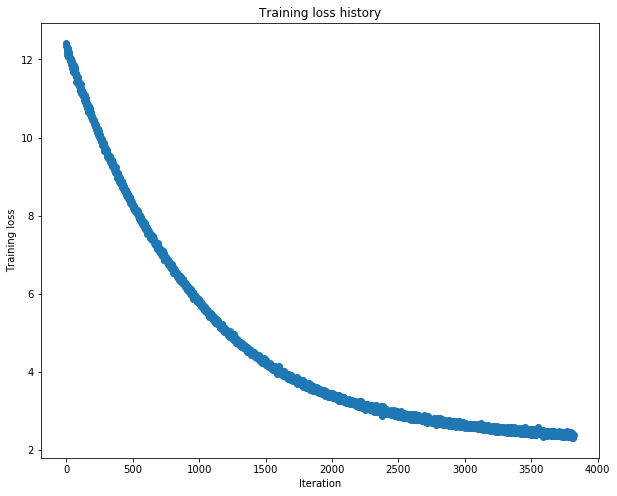

In [79]:
model = FullyConnectedNet([200, 200, 200, 200, 200], use_batchnorm=True, dropout=0.7, weight_scale=5e-2, reg = 1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4
                },
                verbose=True)

solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()